# Train ClaDec on the activations of the Classifier

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from src.common import get_mnist_train_test, get_mnist_labels_categorical, load_layer_activations, get_optimizer
from src.perfectAE.models import SAVED_CLASSIFIER_PATH, SAVED_CLADEC_PATH, get_cladec

tf.random.set_seed(1234)

train_images, test_images = get_mnist_train_test()
train_labels_c, test_labels_c = get_mnist_labels_categorical()

In [2]:
# get the trained model and check accuracy on test data for later reference
classifier = keras.models.load_model(SAVED_CLASSIFIER_PATH)
classifier.evaluate(test_images, test_labels_c)

2022-05-27 16:21:10.189746: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 16:21:10.317914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 16:21:10.318431: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 16:21:10.319785: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

313/313 [==============================] - 4s 4ms/step - loss: 0.0367 - categorical_accuracy: 0.9899


[0.036684636026620865, 0.9898999929428101]

In [3]:
# get the activations
(dense_train_acts, dense_test_acts), (conv_train_acts, conv_test_acts) = load_layer_activations(SAVED_CLASSIFIER_PATH)
conv_train_acts.shape

(60000, 7, 7, 64)

In [4]:
optimizer = get_optimizer(0.00075)
alpha = 0.00
model_alpha_path = SAVED_CLADEC_PATH.joinpath(f'{alpha * 100:2.0f}')
classifier.trainable = False

## ClaDec with decoder for the 128 neuron Dense Layer

In [5]:
model = get_cladec(classifier, alpha, isDense=True)
model.summary()  # note that the classifier is used in loss but not part of training

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 1, 128)    0           ['input_1[0][0]']                
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 4, 4, 64)    131136      ['reshape[0][0]']                
 ose)                                                                                             
                                                                                                  
 conv2d_transpose_1 (Conv2DTran  (None, 9, 9, 32)    18464       ['conv2d_transpose[0][0]']   

In [6]:
# input for ClaDec and loss function
train_dense_input = [dense_train_acts, train_labels_c, train_images]
test_dense_input = [dense_test_acts, test_labels_c, test_images]
model.compile(optimizer=optimizer)
model.fit(x=train_dense_input, epochs=6)

2022-05-27 16:21:23.426511: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.
2022-05-27 16:21:23.919060: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/6
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0497
Epoch 2/6
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0293
Epoch 3/6
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0247
Epoch 4/6
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0229
Epoch 5/6
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0219
Epoch 6/6
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0213


In [7]:
classifier.evaluate(test_images, test_labels_c)  # same as before - classifier not changed

313/313 [==============================] - 1s 4ms/step - loss: 0.0367 - categorical_accuracy: 0.9899


[0.036684636026620865, 0.9898999929428101]

In [8]:
model.evaluate(test_dense_input)
# no amsgrad eps 1e-04 5 epochs
# lr - test loss
# 0.001 - 0.0218
# 0.0005 - 0.0221
# 0.005 - no learning...
# 0.00075 - 0.0216

# with amsgrad and eps 1e-04
# 0.001 - 0.0232

# with amsgrad and eps 1e-07
# 0.001 - 0.0248


313/313 [==============================] - 2s 5ms/step - loss: 0.0214


0.021375661715865135

In [9]:
# get actual decoder
from keras.models import Model

claDec = Model(model.input[0], model.output)
dense_explain = claDec.predict(dense_test_acts)

In [10]:
claDec.save(model_alpha_path.joinpath('dense'))
claDec.summary()

2022-05-27 16:24:38.063264: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/tom/Uni_Dev/cladec-mnist/saved-models/perfectAE/cladec/ 0/dense/assets
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 64)         131136    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 9, 9, 32)         18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289       
 ranspose)   

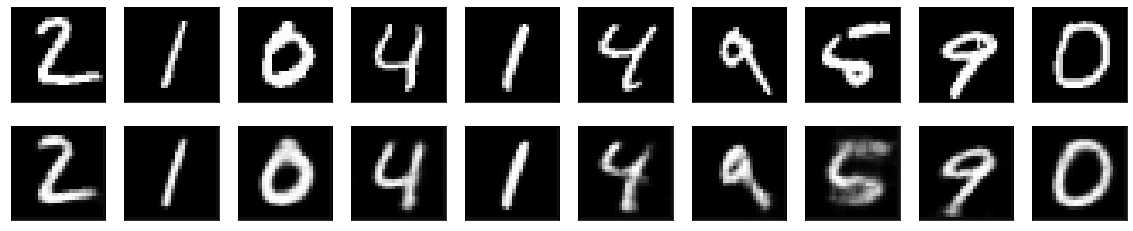

In [11]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(test_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(dense_explain[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## ClaDec with Decoder for the last convolutional layer

In [12]:
# input for ClaDec and loss function
train_conv_input = [conv_train_acts, train_labels_c, train_images]
test_conv_input = [conv_test_acts, test_labels_c, test_images]
model = get_cladec(classifier, alpha, isDense=False)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 7, 7, 64)]   0           []                               
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 14, 14, 64)  65600       ['input_4[0][0]']                
 spose)                                                                                           
                                                                                                  
 input_6 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 28, 28)]     0           []                         

In [13]:
model.compile(optimizer=optimizer)
model.fit(x=train_conv_input, epochs=10)

2022-05-27 16:34:06.504540: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 752640000 exceeds 10% of free system memory.
2022-05-27 16:34:08.619356: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.
2022-05-27 16:34:08.881268: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 752640000 exceeds 10% of free system memory.


Epoch 1/10
1875/1875 [==============================] - 19s 9ms/step - loss: 0.0067
Epoch 2/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0032
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0028
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0026
Epoch 5/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0024
Epoch 6/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0023
Epoch 7/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0022
Epoch 8/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0022
Epoch 9/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0021
Epoch 10/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0021


In [14]:
model.evaluate(test_conv_input)
# no amsgrad eps 1e-04 5 epochs
# lr - test loss
# 0.001 - 0.03
# 0.00075 - 0.023 

# two times 5 epochs - 0.0199

313/313 [==============================] - 2s 5ms/step - loss: 0.0021


0.00207201368175447

In [15]:
# get actual decoder
claDec = Model(model.input[0], model.output)
conv_explain = claDec.predict(conv_test_acts)
claDec.save(model_alpha_path.joinpath('conv'))

INFO:tensorflow:Assets written to: /home/tom/Uni_Dev/cladec-mnist/saved-models/perfectAE/cladec/ 0/conv/assets


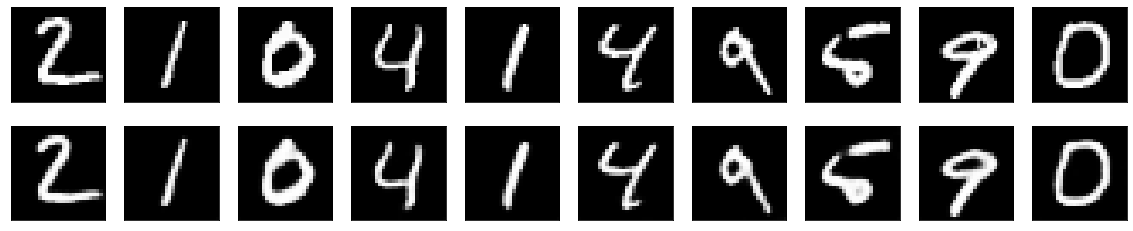

In [16]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(test_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(conv_explain[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()